In [22]:
import sys, os
# os.environ["THEANO_FLAGS"] = "device=cuda"  # use gpu
sys.path.append("../../../")
import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import topology_numpy as tpn
import warnings
warnings.filterwarnings("ignore")
import logging
from importlib import reload
from copy import copy

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Active grids: ['regular']
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!


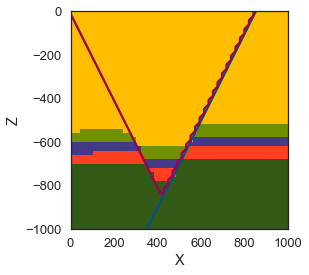

In [4]:
geo_model = gp.load_model(
    'Tutorial_ch1-9b_Fault_relations', 
    path= '../../data/gempy_models', 
    recompile=True
)
gp.compute_model(geo_model)
gp.plot.plot_section(geo_model, show_data=True)

In [5]:
res = geo_model.grid.regular_grid.resolution
lb = np.round(geo_model.solutions.block_matrix[-1, 0, :]).astype(int)
fb = np.round(geo_model.solutions.block_matrix[:-1, 0, :]).astype(int)

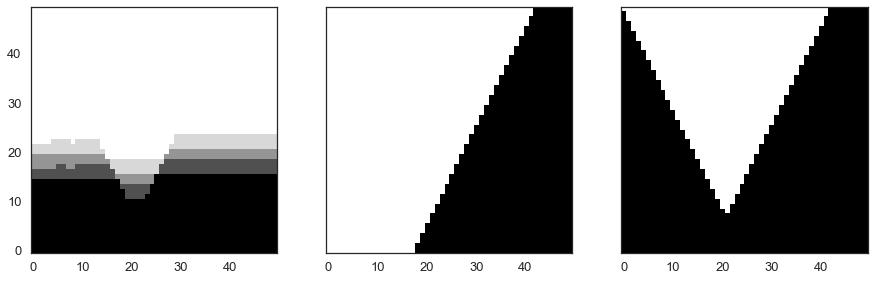

In [6]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15,8))

for ax, block in zip(axs, (lb, *fb)):
    ax.imshow(block.reshape(*res)[:, 24, :].T, origin="lower")

In [7]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
7,fault2,fault_series2,1,False,#015482,1
5,fault1,fault_series1,1,False,#9f0052,2
6,rock4,series1,1,False,#ffbe00,3
0,rock3,series1,2,False,#728f02,4
3,rock2,series1,3,False,#443988,5
1,rock1,series1,4,False,#ff3f20,6
4,basement,basement_series,1,True,#325916,7


In [8]:
geo_model.faults

,isFault,isFinite
fault_series2,True,False
fault_series1,True,False
series1,False,False
basement_series,False,False


In [15]:
logging.basicConfig(level=logging.DEBUG, format='%(message)s')

In [470]:
reload(tpn)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [471]:
from logging import debug

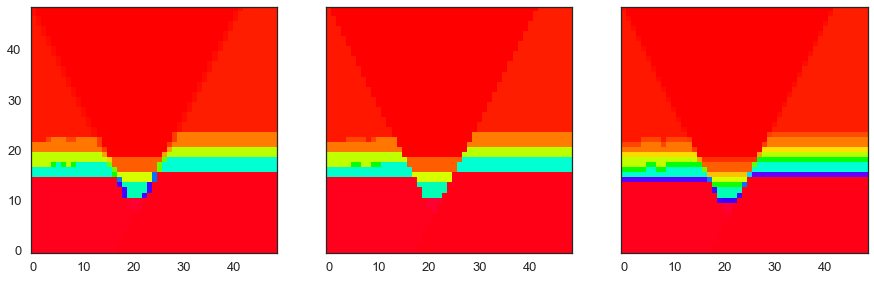

In [613]:
# labels, olabels = tpn.get_labels_block(geo_model)
lb, fb = tpn.lithblock_to_lb_fb(geo_model)
labels = tpn.get_labels_block(lb, fb).reshape(50, 50, 50)
shift_blocks = tpn.get_topo_block(labels, n_shift=1)

fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15,8))

for ax, img in zip(axs, shift_blocks):
    ax.imshow(img[:, 24, :].T, origin="lower", cmap="hsv")

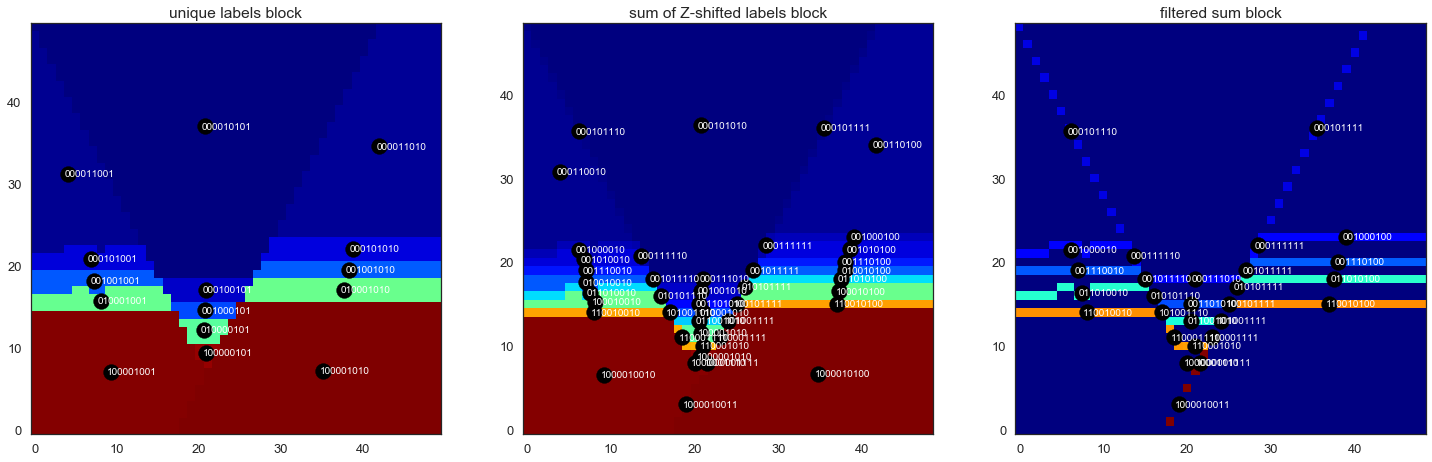

In [617]:
logger.setLevel(logging.CRITICAL)

topo_block = copy(shift_blocks[-1])
topo_block_filtered = copy(shift_blocks[-1])
topo_block_filtered[np.isin(topo_block_filtered, 2*np.unique(labels))] = 0

diff_ctrs = tpn.get_centroids(topo_block)
diff_ctrs_filtered = tpn.get_centroids(topo_block_filtered)

fig, axs = plt.subplots(figsize=(25,10), ncols=3)

labels_ctrs = tpn.get_centroids(labels)
ax = axs[0]
for k, v in labels_ctrs.items():
    ax.scatter(v[0], v[2], c="k", s=250)
    ax.text(v[0]-0.4, v[2]-0.3, np.binary_repr(k).zfill(9), c="w")
ax.set_title("unique labels block")
ax.imshow(labels[:, 24, :].T, origin="lower", cmap="jet")

ax = axs[1]
for k, v in diff_ctrs.items():
    if k == 0:
        continue
    ax.scatter(v[0], v[2], c="k", s=250)
    ax.text(v[0]-0.4, v[2]-0.3, np.binary_repr(k).zfill(9), c="w")
ax.set_title("sum of Z-shifted labels block")
ax.imshow(topo_block[:, 24, :].T, origin="lower", cmap="jet")

ax = axs[2]
for k, v in diff_ctrs_filtered.items():
    if k == 0:
        continue
    ax.scatter(v[0], v[2], c="k", s=250)
    ax.text(v[0]-0.4, v[2]-0.3, np.binary_repr(k).zfill(9), c="w")
ax.set_title("filtered sum block")
ax.imshow(topo_block_filtered[:, 24, :].T, origin="lower", cmap="jet")

In [620]:
ulabel_LOT = tpn.get_node_label_sum_lot(ulabels)

In [621]:
# create layer id LOT
layer_ids = {np.binary_repr(2**i).zfill(9):i for i in range(4, 9)}
print(layer_ids)

{'000010000': 4, '000100000': 5, '001000000': 6, '010000000': 7, '100000000': 8}


# Speed comparison

In [628]:
logger.setLevel(logging.CRITICAL)

In [636]:
%%timeit
lb, fb = tpn.lithblock_to_lb_fb(geo_model)
labels = tpn.get_labels_block(lb, fb).reshape(50, 50, 50)
shift_blocks = tpn.get_topo_block(labels, n_shift=1)
shift_blocks[np.isin(shift_blocks, 2*np.unique(labels))] = 0
edges = tpn.get_edges(shift_blocks, labels, 1)
centroids = tpn.get_centroids(labels)
node_to_layer_LOT = tpn.get_lith_lot(labels, 2)

52.9 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [630]:
%%timeit
G, c = tp.compute_topology(geo_model, filter_rogue=True, compute_areas=False)

382 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [631]:
print(f"Speed-up: {375  / 50.7:.02f}x" )

Speed-up: 7.40x


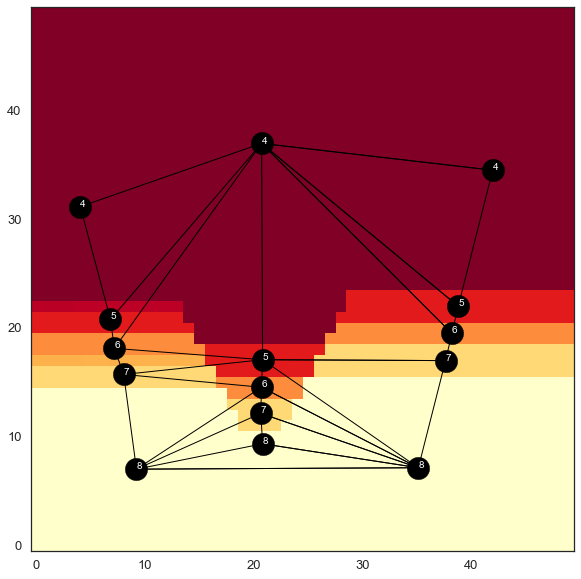

In [634]:
fig = plt.figure(figsize=(10,10))
plt.imshow(geo_model.solutions.block_matrix[-1].reshape(50,50, 50)[:, 24, :].T, origin="lower", cmap="YlOrRd_r")

for edge in edges:
    e1, e2 = edge
    p1 = centroids.get(e1)
    p2 = centroids.get(e2)
    x = (p1[0], p2[0])
    y = (p1[2], p2[2])
    plt.plot(x, y, c="k", linewidth=1)
    
for node in ulabels:
    p = centroids.get(node)
    plt.scatter(p[0], p[2], c="k", s=500)
    plt.text(p[0], p[2], str(node_to_layer_LOT[node]), c="w")

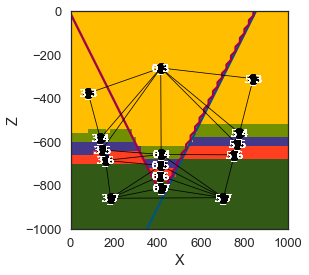

In [635]:
from gempy.assets import topology as tp
G, c = tp.compute_topology(geo_model, filter_rogue=True)
gp.plot.plot_section(geo_model, 24)
gp.plot.plot_topology(geo_model, G, c)